In [88]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import warnings # Supress warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("./files/scaled_w.csv", index_col=0)
df.index = pd.to_datetime(df.index, format = '%Y-%m-%d')
num = 5


df

,Rainfall,Depth_to_Groundwater,Temperature,Drainage_Volume,River_Hydrometry
Date,,,,,
2009-01-11,0.009231,0.189319,0.054659,0.498140,0.288
2009-01-18,0.012308,0.212431,0.166667,0.601207,0.280
2009-01-25,0.043077,0.244689,0.263889,0.824989,0.312
2009-02-01,0.000000,0.260031,0.142921,0.768442,0.432
2009-02-08,0.106667,0.280586,0.266577,0.712806,0.464
...,...,...,...,...,...
2020-05-31,0.227692,0.614280,0.524194,0.685346,0.344
2020-06-07,0.201026,0.621755,0.599014,0.715012,0.360
2020-06-14,0.441026,0.616837,0.572581,0.707264,0.544


In [68]:
target = ['Depth_to_Groundwater']
features = [feature for feature in df.columns if feature not in target]

In [69]:
features

['Rainfall', 'Temperature', 'Drainage_Volume', 'River_Hydrometry']

array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>], dtype=object)

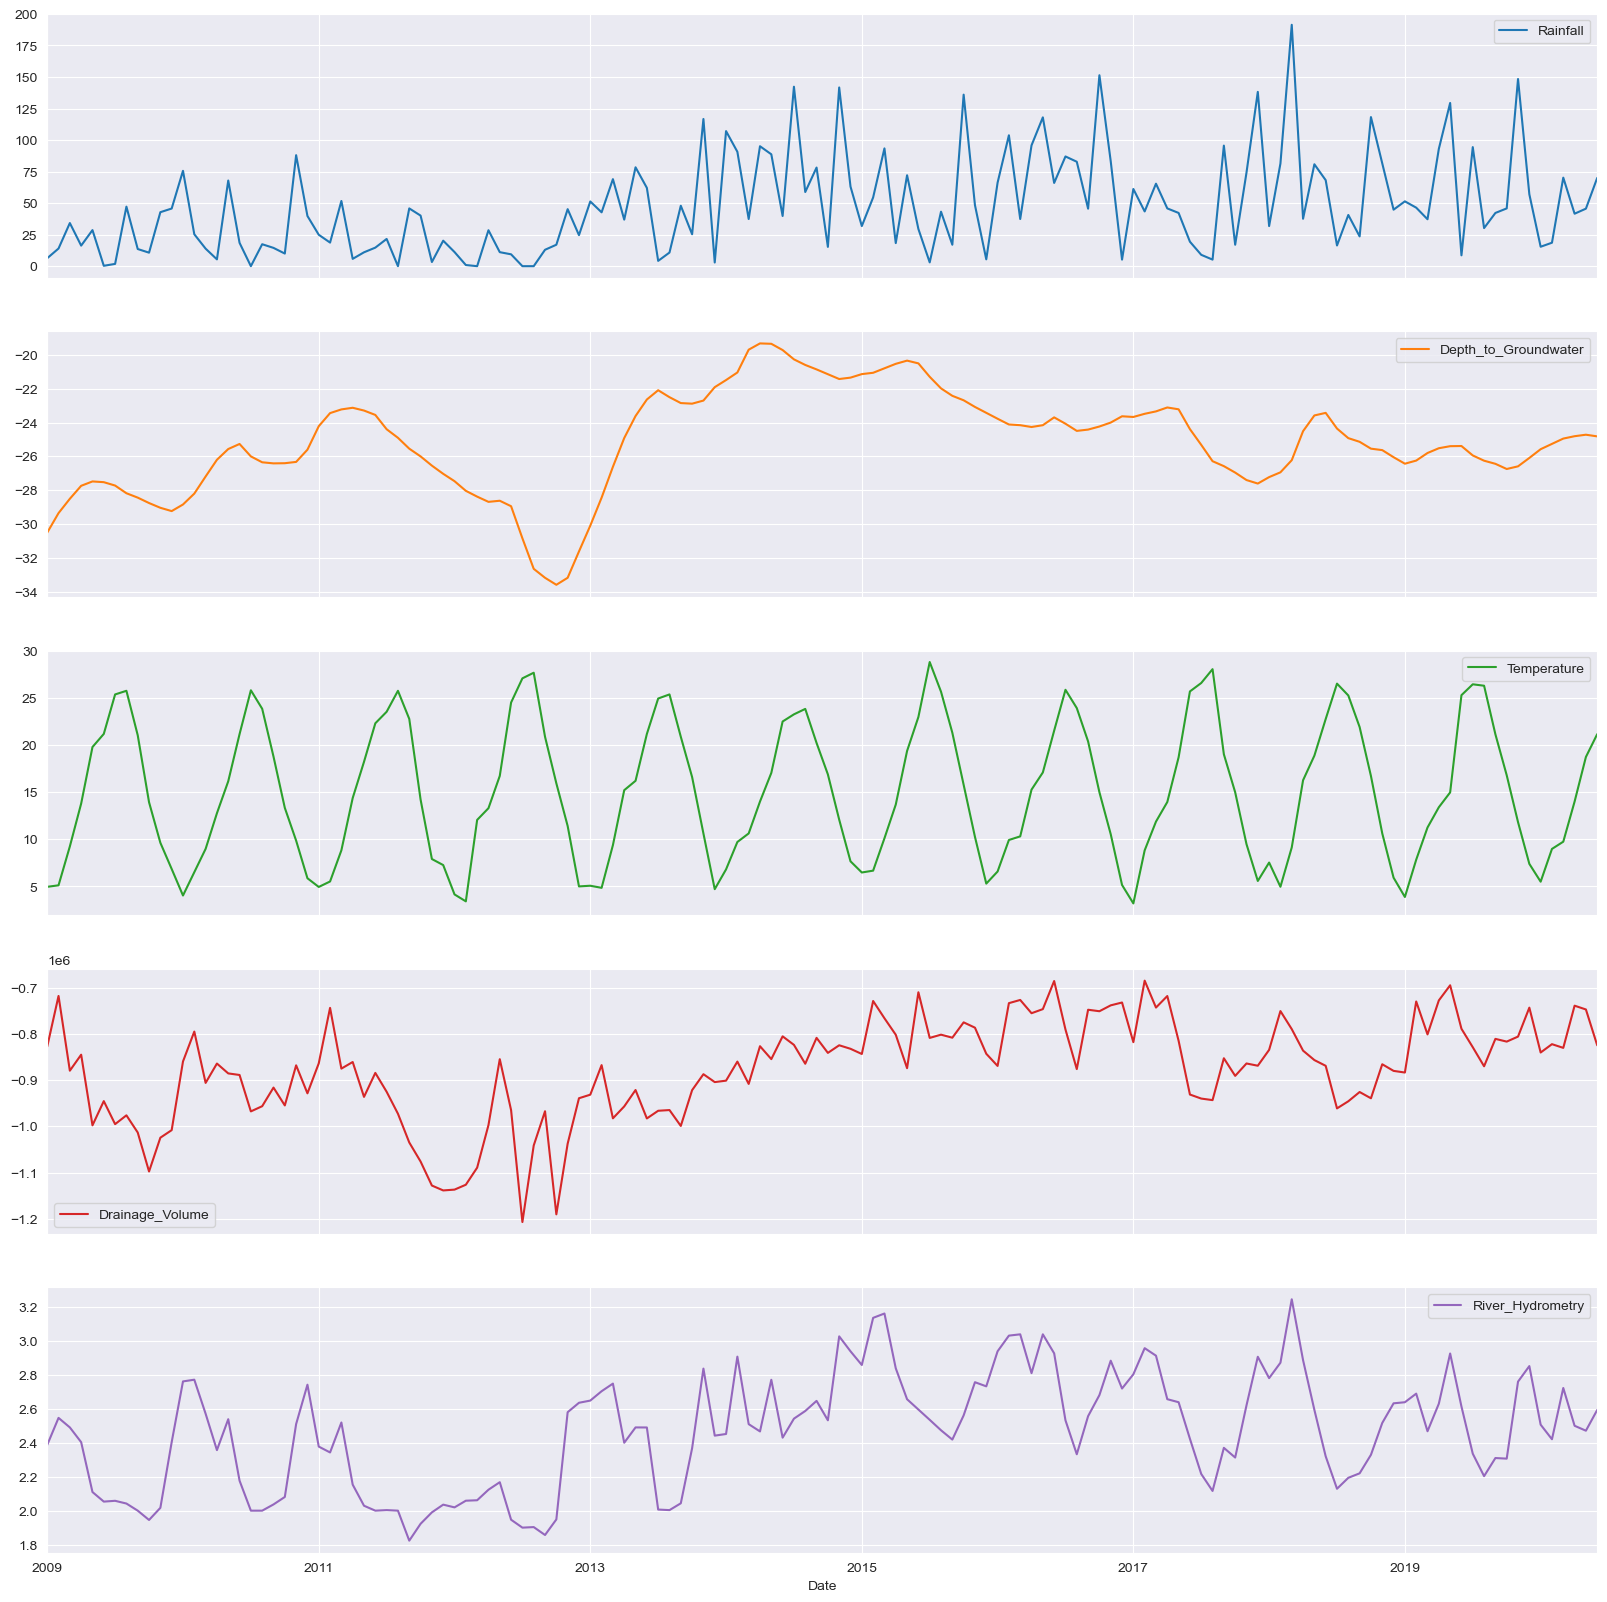

In [49]:
df.plot(subplots=True, figsize=(20, 20))

In [89]:
def split_data():
    testSize = int(0.3 * len(df))
    train= df.iloc[:-testSize]
    test= df.iloc[-testSize:]
    return train, test
train, test = split_data()

In [90]:
testSize = int(0.3 * len(df))
testSize

179

In [91]:
# Find the optimal ARIMAX model order using auto_arima
auto_model = auto_arima(
    train[target],
    exogenous=train[features],
    seasonal=True,  # Set to True for seasonal data
    stepwise=True,
    suppress_warnings=True,
    error_action="ignore",
    max_order=None,  # You can limit the search space for orders
    trace=True,
    m = 52
)

# Get the selected order
order = auto_model

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=-2797.603, Time=6.20 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=-2454.244, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=-2757.741, Time=3.33 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=-2639.419, Time=3.12 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=-2452.708, Time=0.06 sec
 ARIMA(2,1,2)(0,0,1)[52] intercept   : AIC=-2798.427, Time=6.21 sec
 ARIMA(2,1,2)(0,0,0)[52] intercept   : AIC=-2795.248, Time=0.18 sec
 ARIMA(2,1,2)(0,0,2)[52] intercept   : AIC=-2797.517, Time=24.74 sec
 ARIMA(2,1,2)(1,0,0)[52] intercept   : AIC=-2798.804, Time=3.01 sec
 ARIMA(2,1,2)(2,0,0)[52] intercept   : AIC=-2797.560, Time=16.49 sec
 ARIMA(2,1,2)(2,0,1)[52] intercept   : AIC=-2795.287, Time=15.97 sec
 ARIMA(1,1,2)(1,0,0)[52] intercept   : AIC=-2795.183, Time=1.85 sec
 ARIMA(2,1,1)(1,0,0)[52] intercept   : AIC=-2797.301, Time=6.91 sec
 ARIMA(3,1,2)(1,0,0)[52] intercept   : AIC=-2798.689, Time=4.63 sec
 A

In [92]:
order

ARIMA(order=(2, 1, 2), scoring_args={}, seasonal_order=(1, 0, 0, 52),
      suppress_warnings=True)

In [93]:
#open text file
text_file = open("C:\\Users\\poeppelmann\\DataspellProjects\\dsProject\\order\\SARIMAX_order_"+str(num)+".txt", "w")

#write string to file
text_file.write(str(order))

#close file
text_file.close()

In [94]:
def fit_arimax(df):
    model = ARIMA(endog=df[target], exog=df[features], order=order.order, seasonal_order=order.seasonal_order)
    model=model.fit()
    return model

In [95]:
model = fit_arimax(train)
predictions = model.predict(start=test.index[0], end=test.index[-1], exog=test[features])

<Axes: xlabel='Date'>

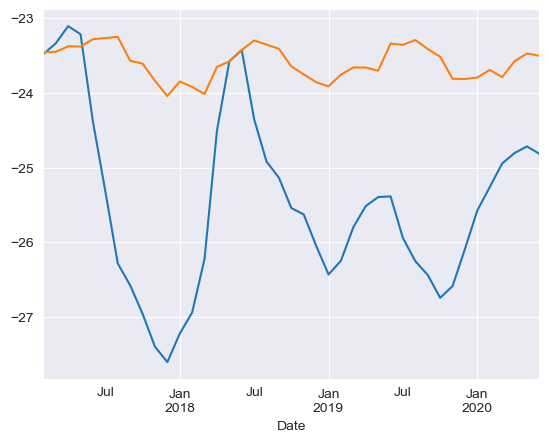

In [56]:

test['Depth_to_Groundwater'].plot(label=True)
predictions.plot(label=True)

In [96]:
# Rolling ARIMA algorithm
def arimax_roll():
    history = train.copy()
    predictions = pd.Series()

    for t in range(len(test)):
        model = fit_arimax(history)
        hat = model.forecast(steps=1, exog=history[features].iloc[[-1]])  # Forecast one step ahead
        predictions = predictions.append(hat)

        # Update history and exogenous history for the next iteration
        history = history.append(test.iloc[t])
    return predictions

In [97]:
predictions = arimax_roll()

In [98]:
predictions

2017-01-29    0.686666
2017-02-05    0.695240
2017-02-12    0.704180
2017-02-19    0.699442
2017-02-26    0.701789
                ...   
2020-05-31    0.620591
2020-06-07    0.614999
2020-06-14    0.624513
2020-06-21    0.615253
2020-06-28    0.615537
Freq: W-SUN, Length: 179, dtype: float64

<Axes: xlabel='Date'>

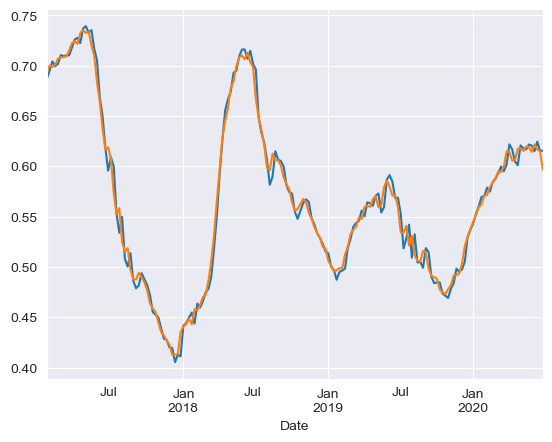

In [99]:
predictions.plot()
test['Depth_to_Groundwater'].plot()

In [100]:
predictions.name = 'Depth_to_Groundwater'
predictions.to_csv('predictions/SARIMAX/'+str(num)+'.csv')

In [101]:
saved_sr = pd.read_csv('./predictions/ARIMA/'+str(num)+'.csv', index_col=0)
saved_sr.index = pd.to_datetime(saved_sr.index, format = '%Y-%m-%d')

In [102]:
saved_sr = predictions

In [103]:
metrics = {}
def calc_metrics():

    results = pd.DataFrame(data={'Predictions':saved_sr, 'Actuals':df['Depth_to_Groundwater']}, index=saved_sr.index)

    # Step 2: Calculate the differences between the predicted and actual values
    results['Difference'] = results['Actuals'] - results['Predictions']

    # Step 3: Calculate squared differences for RMSE
    results['Squared_difference'] = results['Difference'] ** 2

    # Step 4: Calculate absolute differences for MAE and MAPE
    results['Absolute_difference'] = np.abs(results['Difference'])
    results['Absolute_percentage_difference'] = np.abs(results['Difference'] / results['Actuals'])

    # Step 5: Compute the metrics
    rmse = np.sqrt(results['Squared_difference'].mean())
    mae = results['Absolute_difference'].mean()
    mape = results['Absolute_percentage_difference'].mean() * 100  # to get the percentage
    return rmse, mae, mape

rmse, mae, mape = calc_metrics()
metrics['Depth_to_Groundwater'] = {
    'RMSE': rmse,
    'MAE': mae,
    'MAPE': mape
}
metrics_df = pd.DataFrame(metrics)

In [104]:
metrics_df

,Depth_to_Groundwater
MAE,0.006907
MAPE,1.241377
RMSE,0.009416


In [105]:
metrics_df.to_csv('metrics/SARIMAX/'+str(num)+'.csv')

array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>], dtype=object)

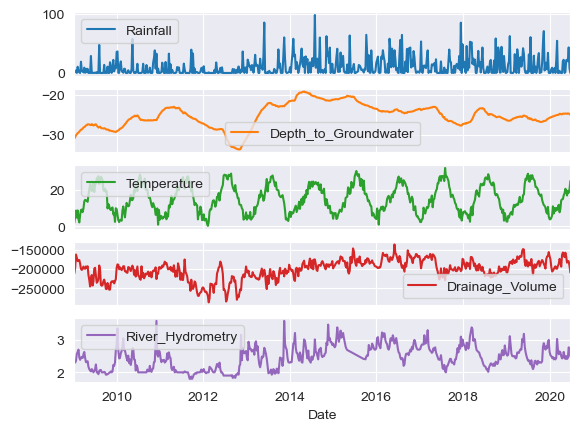

In [86]:
df.plot(subplots=True)